In [2]:
%pylab inline
import numpy as np
import pandas as pd
from scipy import stats

# Make the graphs a bit prettier, and bigger
from matplotlib import pyplot as plt
from matplotlib import cm
plt.style.use('ggplot')
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 10) 

import seaborn as sns
#sns.set(color_codes=True)

from jupyterthemes import jtplot
jtplot.style()

figsize(20, 10)

Populating the interactive namespace from numpy and matplotlib


In [88]:
# Set up some global stuff
euro_format = FuncFormatter(lambda x, _: '€{:,}'.format(int(x)))
dollar_format = FuncFormatter(lambda x, _: '${:,}'.format(int(x)))

# Get survey
survey = pd.read_csv('survey_results_public.csv')
list(survey._get_numeric_data())

['Respondent',
 'CareerSatisfaction',
 'JobSatisfaction',
 'HoursPerWeek',
 'StackOverflowSatisfaction',
 'Salary',
 'ExpectedSalary']

# Problem with salary data
The salary data looks as some participants have reported their monthly or hourly income instead of their annual, as requested.

We will try to resolve this by finding the best threshold salary for which values below should be considered monthly. The same should also be considered for hourly.

c:\python36\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


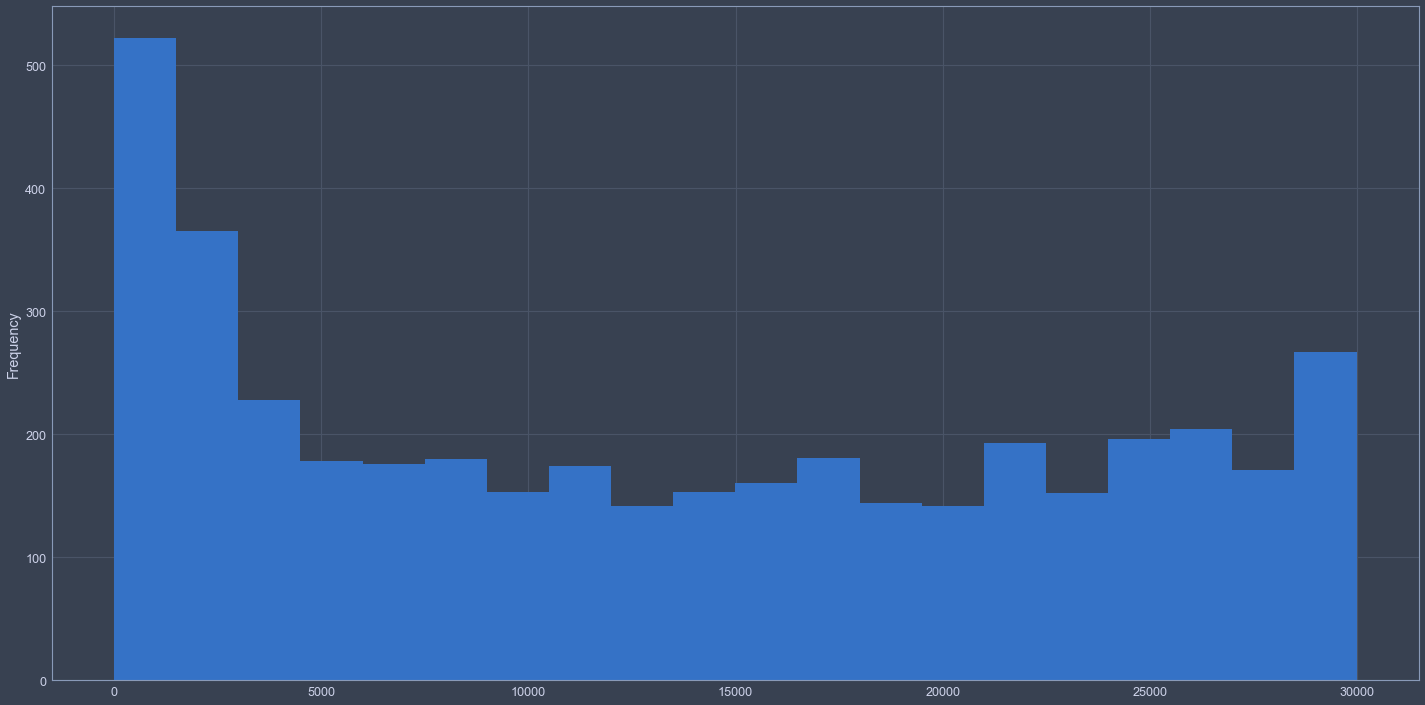

In [90]:
in_germany = survey['Country'] == 'Germany'
is_salaried = survey['Salary'].notnull()
usd2eur = 0.897087
germans = survey[is_salaried]
salary_de = (germans['Salary'] * usd2eur)

# Find participants who have incorrectly reported monthy wage
# Need to find threshold for monthly / yearly wages
salary_de[salary_de.where(salary_de < 30000).notnull()].plot.hist(bins=20)

Looks like its around 10,000 EUR.

Now we know to treat wages below 10,000 as month wages, and wages below 200 as hourly.

In [100]:
def get_country_salary_eur(country):
    usd2eur = 0.897087
    is_salaried = survey['Salary'].notnull()
    in_country = survey['Country'] == country
    citizens = survey[in_country & is_salaried]
    return (citizens['Salary'] * usd2eur).rename(country)

def fix_salary(salary):
    salary = salary.where(salary > 200, salary * 2080)
    salary = salary.where(salary > 5000, salary * 12)
    return salary

survey['Salary'] = fix_salary(survey['Salary'])

# Comparison of developer salaries by country
The countries considered here are Australia (my homeland), Germany (my current country of residence), Norway (my employer's country of residence) and the United States (as a high-salary benchmark).

c:\python36\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


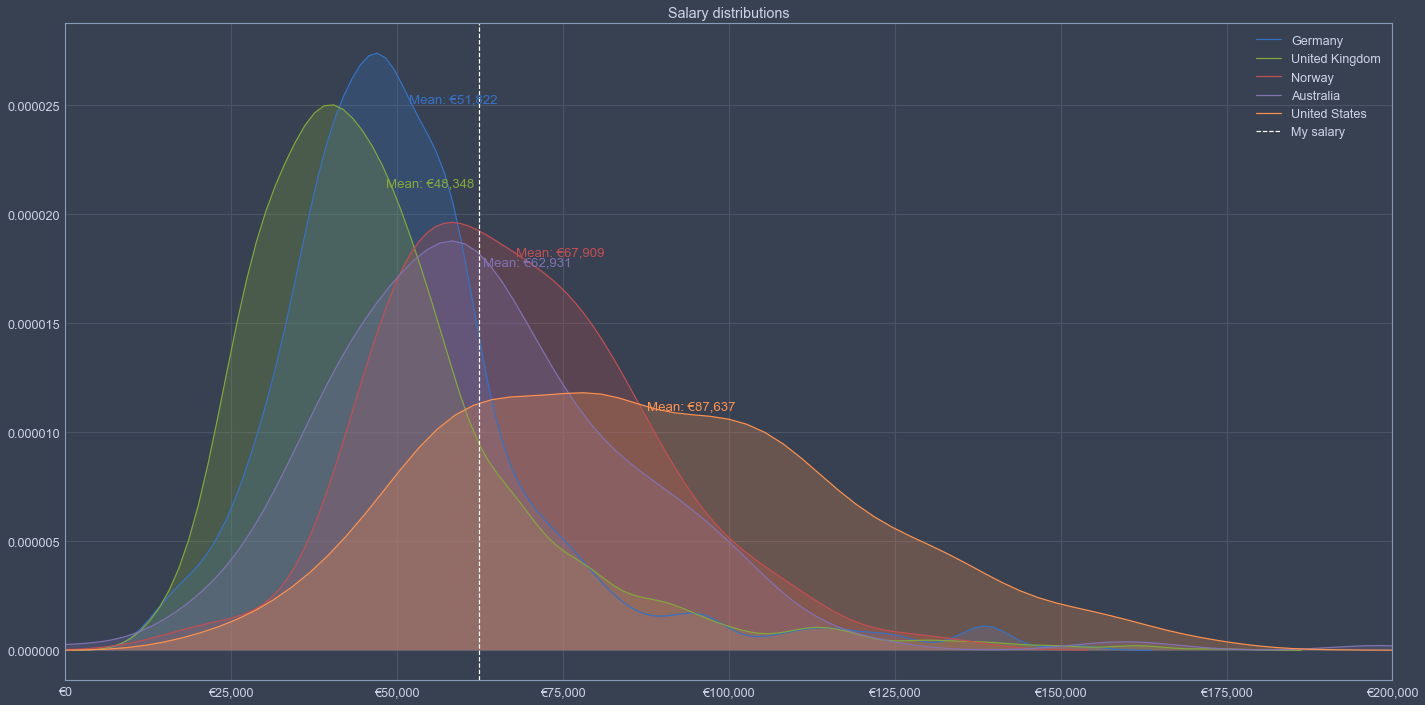

In [101]:
salary_de = get_country_salary_eur('Germany')
salary_uk = get_country_salary_eur('United Kingdom')
salary_no = get_country_salary_eur('Norway')
salary_au = get_country_salary_eur('Australia')
salary_us = get_country_salary_eur('United States')

def plot_mean(series):
    line = ax.get_lines()[-1]
    mean = series.mean()
    y = next(coord[1] for coord in line.get_xydata() if coord[0] >= mean)
    ax.annotate("Mean: " + euro_format(mean), xy=(mean, y), color=line.get_color())

# Plot it up
ax = sns.kdeplot(salary_de, shade=True)
plot_mean(salary_de)
sns.kdeplot(salary_uk, shade=True)
plot_mean(salary_uk)
sns.kdeplot(salary_no, shade=True)
plot_mean(salary_no)
sns.kdeplot(salary_au, shade=True)
plot_mean(salary_au)
sns.kdeplot(salary_us, shade=True)
plot_mean(salary_us)
ax.axvline(x=2080*30, color='w', ls="dashed", label="My salary")

# Make everything pretty
ax.xaxis.set_major_formatter(euro_format) 
ax.legend(loc=0)
ax.set_xlim([0,200000])
ax.set_title("Salary distributions")

# Developer roles
## Distribution of developer roles of all participants

In [7]:
# Slow
devtypes = survey['DeveloperType'].str.split(';\s+').apply(lambda x: pd.Series(x).value_counts()).sum().astype(int)

c:\python36\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


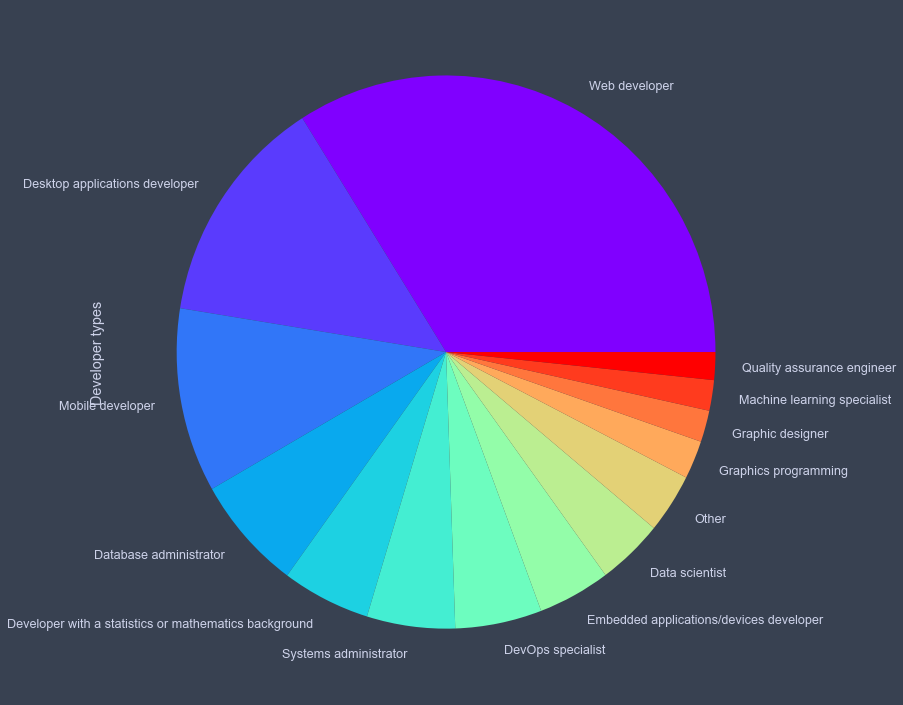

In [8]:
devtypes_freq = devtypes.sort_values(ascending=False).rename("Developer types")
devtypes_freq.plot.pie(figsize=(10,10), cmap='rainbow')

## Salaries of developer types

c:\python36\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


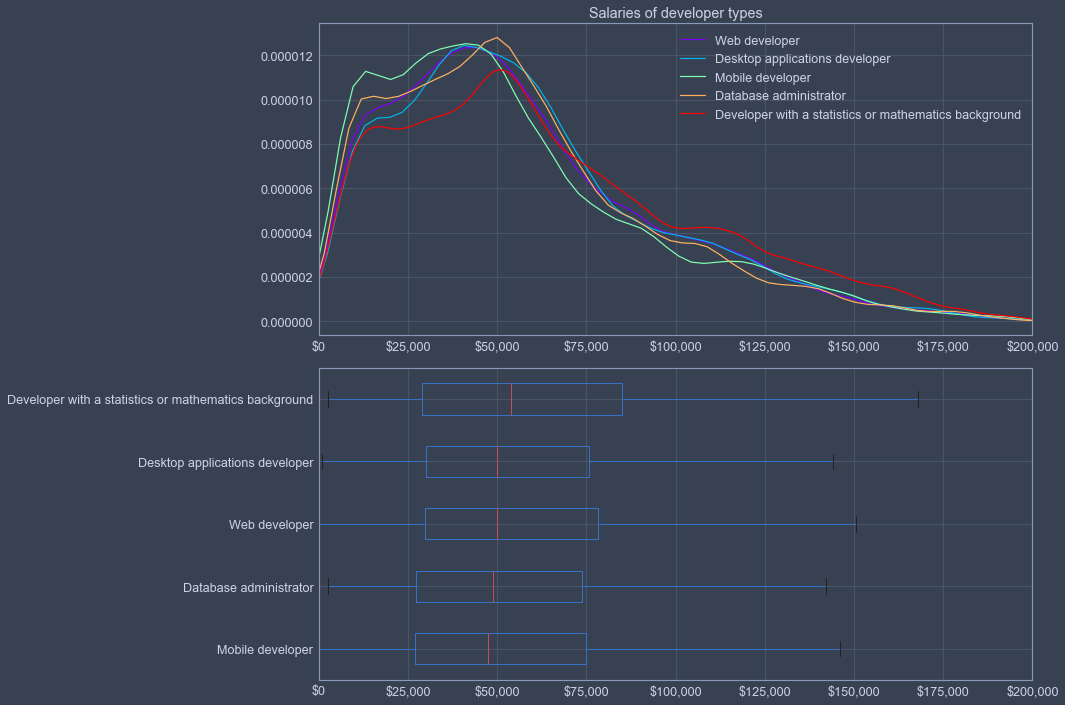

In [9]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 10))
df = pd.DataFrame()
color=iter(cm.rainbow(np.linspace(0,1,5)))
for i, devtype in enumerate(devtypes_freq[:5].index):
    is_devtype = survey['DeveloperType'].str.contains(devtype, regex=False)
    devtype_salary = survey[is_salaried & is_devtype]['Salary']
    devtype_salary = devtype_salary.rename(devtype)
    sns.kdeplot(devtype_salary, ax=axes[0], color=next(color), bw=5000)
    df[devtype] = devtype_salary

## Boxplot, sorted by median
df = df.loc[:, df.median().sort_values(ascending=True).index]
df.plot.box(df, ax=axes[1], vert=False)

axes[0].set_xlim([0,200000])
axes[1].set_xlim([0,200000])
axes[0].xaxis.set_major_formatter(dollar_format) 
axes[1].xaxis.set_major_formatter(dollar_format)
axes[0].set_title("Salaries of developer types")

# Developer language experience
## Distribution of language experience of all participants

In [10]:
# This one is slow on survey
langtypes = survey['HaveWorkedLanguage'].str.split(';\s+').apply(lambda x: pd.Series(x).value_counts()).sum().astype(int)

c:\python36\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


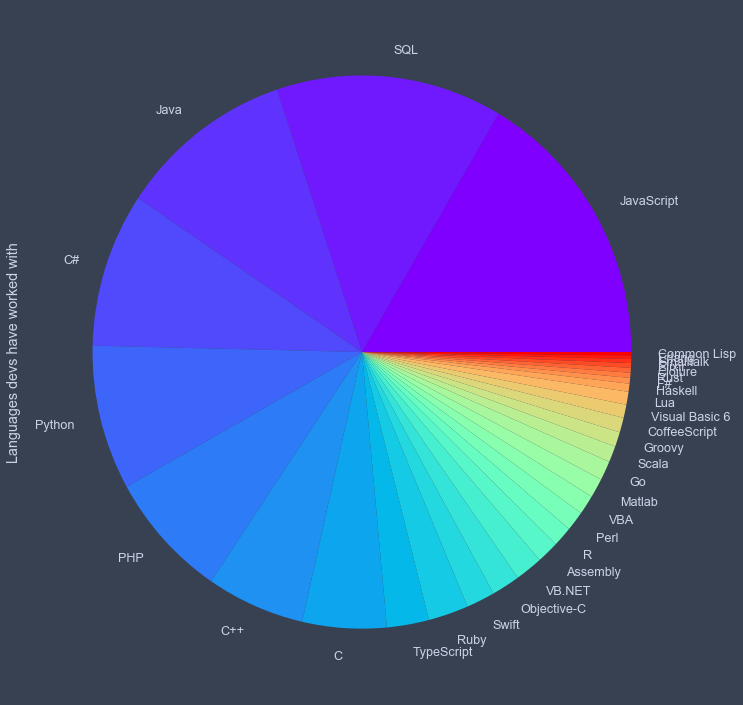

In [31]:
langtypes_freq = langtypes.sort_values(ascending=False).rename("Languages devs have worked with")
langtypes_freq = langtypes_freq[langtypes_freq > 200]
langtypes_freq.plot.pie(figsize=(10,10), cmap='rainbow')

## Salaries of developer who have experience with languages

c:\python36\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


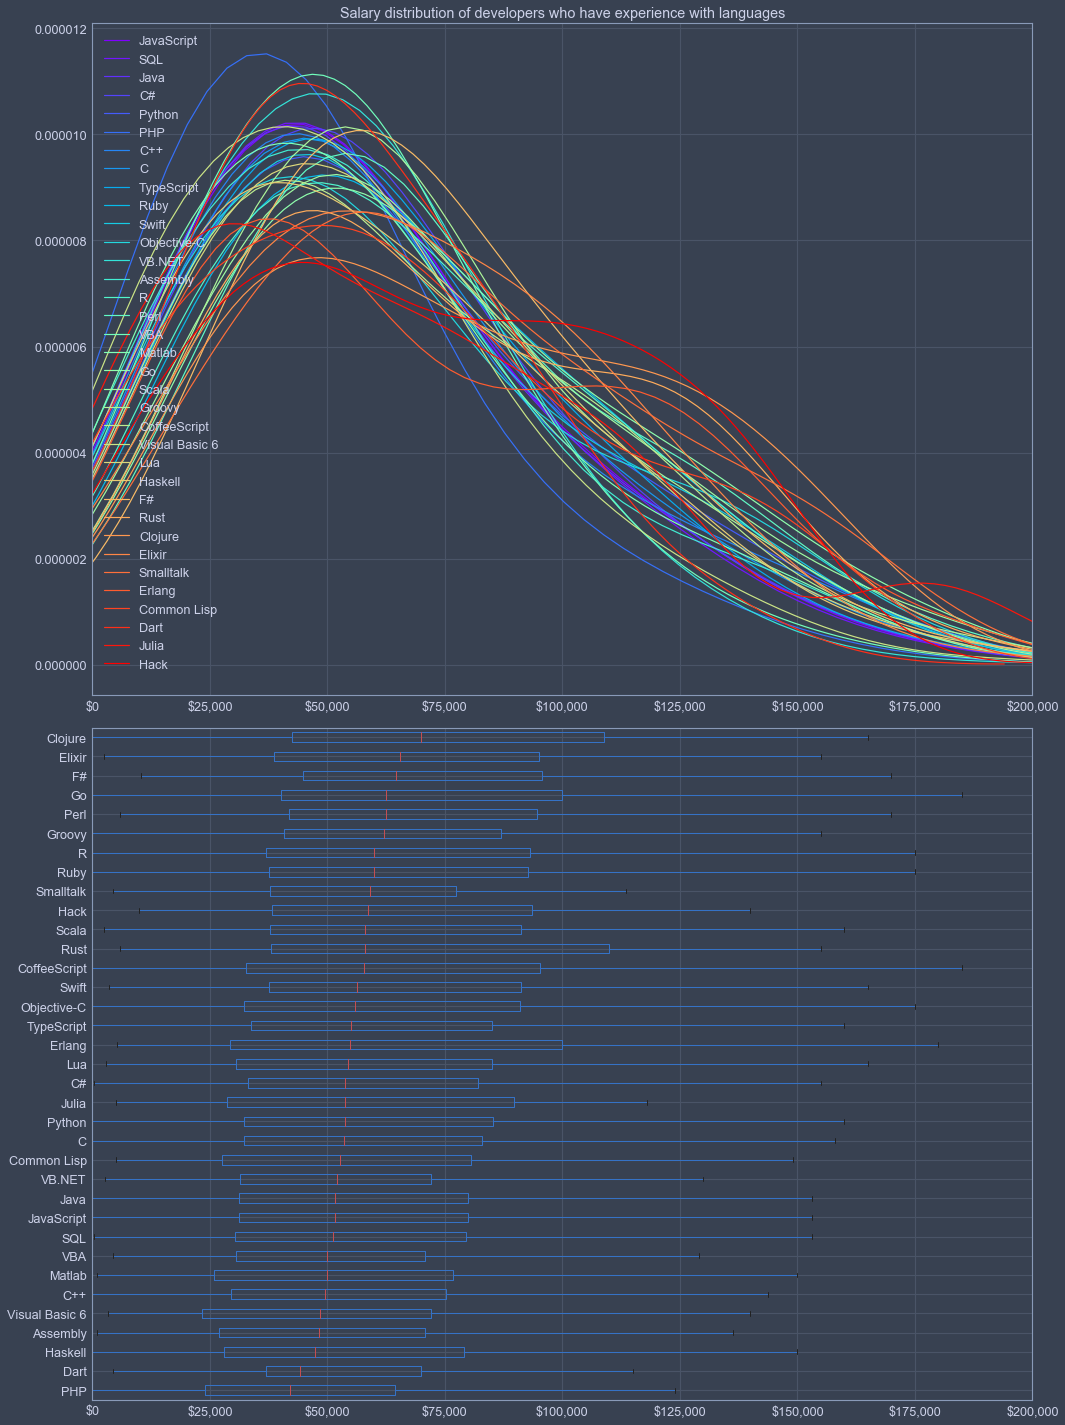

In [30]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 20))
df = pd.DataFrame()
color=iter(cm.rainbow(np.linspace(0,1,langtypes_freq.count())))
for i, lang in enumerate(langtypes_freq.index):
    is_lang = survey['HaveWorkedLanguage'].str.contains(lang, regex=False)
    lang_salary = survey[is_salaried & is_lang]['Salary']
    lang_salary = lang_salary.rename(lang)
    sns.kdeplot(lang_salary, ax=axes[0], color=next(color), bw=20000)
    df[lang] = lang_salary

# Boxplot, sorted by median
df = df.loc[:, df.median().sort_values(ascending=True).index]
df.plot.box(df, ax=axes[1], vert=False)

axes[0].set_xlim([0,200000])
axes[1].set_xlim([0,200000])
axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '${:,}'.format(int(x)))) 
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '${:,}'.format(int(x))))
axes[0].set_title("Salary distribution of developers who have experience with languages")

# Salary and number of experienced languages

c:\python36\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


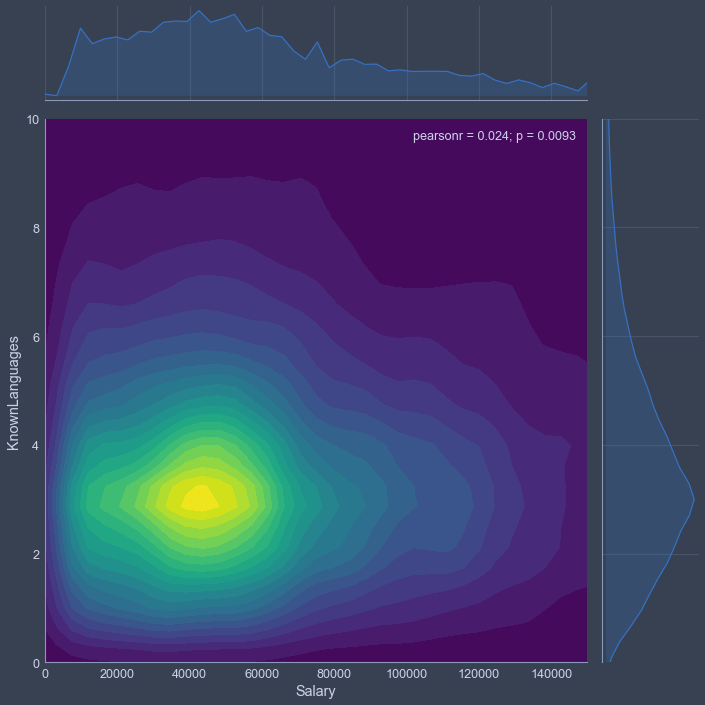

In [13]:
df = pd.DataFrame()
df['Salary'] = survey['Salary']
df['KnownLanguages'] = survey['HaveWorkedLanguage'].str.split(';\s+')
df = df.dropna(axis=0, how='any')
df['KnownLanguages'] = df['KnownLanguages'].apply(lambda x: len(x))

g = sns.JointGrid(x='Salary', y='KnownLanguages', data=df, ylim=(0,10), xlim=(0,150000), size=10)
g.plot_joint(sns.kdeplot, cmap='viridis', n_levels=20, shade=True, bw=[5000, 0.5], stat_func=stats.pearsonr)
g = g.plot_marginals(sns.kdeplot,shade=True, bw=0.5)
g = g.annotate(stats.pearsonr)

As the Pearson's *r* is very close to 0, we can conclude that developer salary and the number of languages they claim to have worked with are **independent**.

# Salary and career satsifaction

c:\python36\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


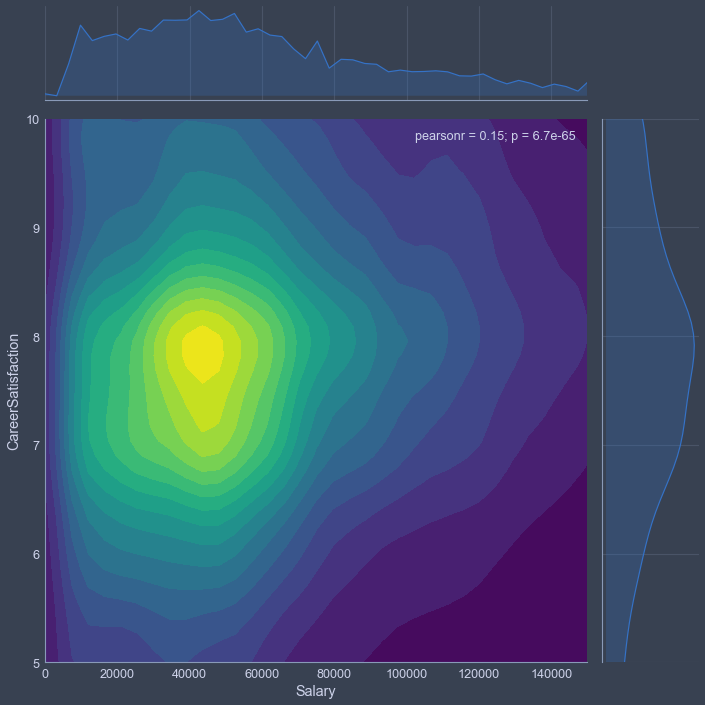

In [14]:
g = sns.JointGrid(x='Salary', y='CareerSatisfaction', data=survey, ylim=(5,10), xlim=(0,150000), size=10)
g.plot_joint(sns.kdeplot, cmap='viridis', n_levels=20, shade=True, bw=[5000, 0.5], stat_func=stats.pearsonr)
g = g.plot_marginals(sns.kdeplot,shade=True, bw=0.5)
g = g.annotate(stats.pearsonr)